In [4]:
import pandas as pd 
import numpy as pd
import metloom
from metloom.pointdata import CDECPointData
import geopandas as gpd 
import matplotlib.pyplot as plt 
import wget
import os

In [2]:
wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")

'cb_2018_us_state_500k.zip'

In [7]:
states = gpd.read_file(os.getcwd()+'/cb_2018_us_state_500k')

In [9]:
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [10]:
california = states[states['NAME']=='California']

In [13]:
california = california.to_crs('epsg:4326')

<Axes: >

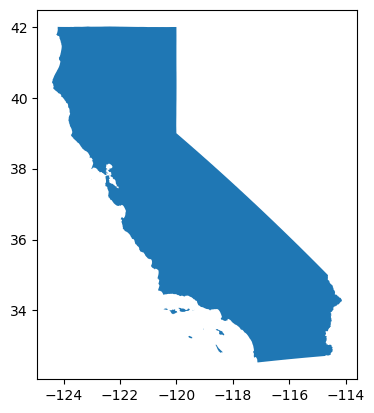

In [14]:
california.plot()

In [15]:
california.to_file('california_outline.geojson', driver='GeoJSON')

In [25]:
fp = 'california_outline.geojson'
obj = gpd.read_file(fp)

vrs = [
    CDECPointData.ALLOWED_VARIABLES.SWE,
    CDECPointData.ALLOWED_VARIABLES.SNOWDEPTH
]

In [27]:

points = CDECPointData.points_from_geometry(obj, vrs, snow_courses=True)
df = points.to_dataframe()
print(df)


                 name   id datasource  \
0          COURTRIGHT  CUR       CDEC   
1          CEDAR PASS  CDP       CDEC   
2       TYNDALL CREEK  TND       CDEC   
3        NORVELL FLAT  NRF       CDEC   
4      WABENA MEADOWS  WBM       CDEC   
..                ...  ...        ...   
249        DUTCH LAKE  DTL       CDEC   
250   CRABTREE MEADOW  CBT       CDEC   
251       BISHOP LAKE  BSP       CDEC   
252  BIG PINE CREEK 2  BP2       CDEC   
253      BEARD MEADOW  BMD       CDEC   

                                      geometry  
0     POINT Z (-118.96500 37.07200 8350.00000)  
1     POINT Z (-120.30300 41.58300 7100.00000)  
2    POINT Z (-118.39200 36.63200 10650.00000)  
3     POINT Z (-121.00700 40.48200 5700.00000)  
4     POINT Z (-120.40200 39.22700 6300.00000)  
..                                         ...  
249   POINT Z (-118.99700 37.25800 9100.00000)  
250  POINT Z (-118.34760 36.56381 10600.00000)  
251  POINT Z (-118.54500 37.12300 11300.00000)  
252   POINT Z (-1

In [28]:
df.head()

,name,id,datasource,geometry
0,COURTRIGHT,CUR,CDEC,POINT Z (-118.96500 37.07200 8350.00000)
1,CEDAR PASS,CDP,CDEC,POINT Z (-120.30300 41.58300 7100.00000)
2,TYNDALL CREEK,TND,CDEC,POINT Z (-118.39200 36.63200 10650.00000)
3,NORVELL FLAT,NRF,CDEC,POINT Z (-121.00700 40.48200 5700.00000)
4,WABENA MEADOWS,WBM,CDEC,POINT Z (-120.40200 39.22700 6300.00000)


<Axes: >

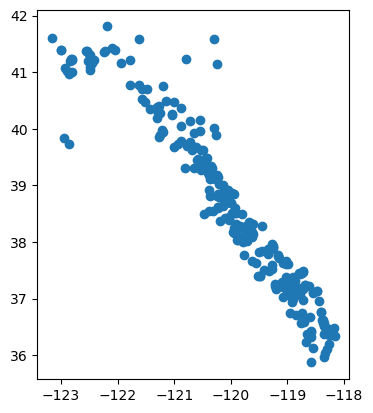

In [29]:
df.plot()

In [ ]:
start_date = datetime(2020,10,1)
end_date = datetime(2023,7,31)

In [ ]:
# Download data for TUM to get the datetime index:
cdec_point = CDECPointData("TUM", "TUM")
tum_depth = cdec_point.get_daily_data(
    start_date, end_date,
    [cdec_point.ALLOWED_VARIABLES.SNOWDEPTH]
)
tum_depth.head()

In [ ]:
# Reindex from a multiindex so I can easily access the datetime index:
tum_depth = tum_depth.reset_index()
tum_depth = tum_depth.set_index('datetime')

# Create a new empty dataframe with the TUM datetime index:
snwd_df = pd.DataFrame()
snwd_df.index = pd.DatetimeIndex(data=tum_depth.index)

# Iteratively download all the data and add the SNOWDEPTH column to the snwd_df:
# Note that the snow depth unit is inches
for i in range(len(cdec_locations)):
    cdec_point = CDECPointData(cdec_locations.id.values[i], cdec_locations.id.values[i])
    cdec_depth = cdec_point.get_daily_data(
        start_date, end_date,
        [cdec_point.ALLOWED_VARIABLES.SNOWDEPTH]
    )
    if cdec_depth is not None:
        cdec_depth = cdec_depth.reset_index()
        cdec_depth = cdec_depth.set_index('datetime')
        snwd_df[f'{cdec_locations.id.values[i]}'] = cdec_depth['SNOWDEPTH']
    else:
        continue
